# Connect to drive 

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# Mount the drive folder. This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)


# Opens the project folder.
%cd '/content/drive/My Drive/PARMA/OpticalFlow/GitRepo/Dataset/gt/'

Mounted at /content/drive
/content/drive/My Drive/PARMA/OpticalFlow/GitRepo/Dataset/gt


# Import modules

In [0]:
import os

#Import necessary packages, torch, numpy, pylab
import torch
from torch.nn import Parameter
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

import pandas as pandas
import numpy as np

# New refactor imports
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# Define dataset functions

In [0]:
class SequenceSinDataset(Dataset):

        def __init__(self, std, sequenceLength, device):
                """
                Function to handle the initialization of the class.
                Creates a [x,y] sample for each timestep
                @param std
                @param sequenceLenght
                """

                #create data steps from 2 to 10 with the given sequence length
                xTimeSteps = np.linspace(2, 10, sequenceLength + 1)
                #create numpy array with sin(x) input
                yNp = np.zeros((2, sequenceLength + 1))
                yNp[1,:] = np.sin(xTimeSteps) + np.random.normal(0, std, xTimeSteps.size)
                yNp[0,:] = xTimeSteps
                
                #yNp.resize((sequenceLength + 1, 1))

                #yInput = Variable(torch.Tensor(Yt[:, :-1]).type(dtype), requires_grad = False).to(device)
                self.yInput = torch.tensor(yNp[:, :-1], dtype=torch.float, device=device, requires_grad=False)
                
                # create the target or ground truth data
                #yTarget = Variable(torch.Tensor(Yt[:, 1:]).type(dtype), requires_grad = False).to(device)
                self.yTarget = torch.tensor(yNp[:, 1:], dtype=torch.float, device=device, requires_grad=False)

                # Normalizes values
                self.yInput = self.yInput / torch.max(self.yInput)
                self.yTarget = self.yTarget / torch.max(self.yTarget)

        def __getitem__(self, index):
                """
                Function that retrieves a sample from the sequence at index position
                @param index
                @return (input, target)
                """

                #current input in the sequence at t
                x = self.yInput[:, index]
                #input = x[t] not like that to create a matrix and not a vector
                
                #current target value at t
                target = self.yTarget[:, index]

                return (x, target)

        def __len__(self):
                """
                Function that retrieves the length of the dataset, by calling len() on the input
                @return size
                """

                return self.yInput.shape[1]


class SequenceDataset(Dataset):
        """
        Class to manage the sequence dataset in a pytorch manner
        """

        def __init__(self, dataset_name, device):
                """
                Function to handle the initialization of the class.
                Calls pandas to read from csv and generates the input and gt matrices
                @param datase(train_loader, val_loader) = get_dataloaders(dataset, batch_size=batch_size, 
                                                        test_percentage=0.2, normalize=normalize)t_name
                @param normalize
                """

                dataFrame = pandas.read_csv(dataset_name)

                Y = dataFrame.values[:,1:]
                Yt = Y.transpose()

                #create the input time series for the model, with one unit of delay, is no model parameter, no grad needed
                #yInput = Variable(torch.Tensor(Yt[:, :-1]).type(dtype), requires_grad = False).to(device)
                self.yInput = torch.tensor(Yt[:, :-1], dtype=torch.float, device=device, requires_grad=False)
                
                # create the target or ground truth data
                #yTarget = Variable(torch.Tensor(Yt[:, 1:]).type(dtype), requires_grad = False).to(device)
                self.yTarget = torch.tensor(Yt[:, 1:], dtype=torch.float, device=device, requires_grad=False)
                
                # Normalizes values
                self.yInput = self.yInput / torch.max(self.yInput)
                self.yTarget = self.yTarget / torch.max(self.yTarget)

        def __getitem__(self, index):
                """
                Function that retrieves a sample from the sequence at index position
                @param index
                @return (input, target)
                """

                #current input in the sequence at t
                x = self.yInput[:, index]
                #input = x[t] not like that to create a matrix and not a vector
                
                #current target value at t
                target = self.yTarget[:, index]

                return (x, target)

        def __len__(self):
                """
                Function that retrieves the length of the dataset, by calling len() on the input
                @return size
                """
                return self.yInput.shape[1]

# Data management functions

In [0]:
def get_dataloaders(dataset, device, test_percent=0.2, batch_size=1, std=0.1):

        # Validate a correct percentage
        test_percent = test_percent/100 if test_percent > 1 else test_percent

        if dataset:
                # Generates the dataset and then creates a loader from it
                dset = SequenceDataset(dataset, device)
        else:
                dset = SequenceSinDataset(std, 3000, device)

        # Calculate separation index for training and validation
        num_train = len(dset)
        indices = list(range(num_train))
        split = int(np.floor(test_percent * num_train))
        np.random.shuffle(indices)
        train_idx, valid_idx = indices[split:], indices[:split]

        # Generates training and validation loaders
        train_loader = DataLoader(dset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
        val_loader = DataLoader(dset, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx))

        return (train_loader, val_loader)

""" 
    Save the state of a net.
"""
def save_checkpoint(state, path='checkpoint/', filename='weights.pth'):
    # If folder does not exists make folder
    if not os.path.exists(path):
        os.makedirs(path)

    filepath = os.path.join(path, filename)
    torch.save(state, filepath)

# Define the network

In [0]:
class ElmanNet(nn.Module):

        """
        This class represents the architecture of the Elman Network
        """
        def __init__(self, contextConcatInputLayerSize, hiddenLayerSize, outputLayerSize, device):
                """
                Creates the matrices for the Elman model, in this case W1 and V
                @param contextConcatInputLayerSize
                @param hiddenLayerSize
                @param outputLayerSize
                """
                super(ElmanNet, self).__init__()

                self.hidden_layer_size = hiddenLayerSize

                # Initializes the W1 matrix
                W1 = torch.zeros((contextConcatInputLayerSize, hiddenLayerSize), dtype=torch.float, device=device)
                self.W1 = Parameter(W1, requires_grad=True)

                #randomly init W1 parameter matrix with mean 0 and std 0.4
                nn.init.normal_(self.W1, 0.0, 0.4)

                # Initializes the V matrix
                V = torch.zeros((hiddenLayerSize, outputLayerSize), dtype=torch.float, device=device)
                self.V = Parameter(V, requires_grad=True)

                # randomly init V parameter matrix with mean 0 and std 0.3
                nn.init.normal_(self.V, 0.0, 0.3)

        def get_hidden_layer_size(self):
                
                """
                Function that retrieves the size of the hidden layer
                """
                return self.hidden_layer_size
        
        def forward(self, x, contextState):

                """
                Model forward pass
                @param input, current input in t
                @param contextState, previous output in (t - 1) the sequence of hidden states
                """
                
                #concatenate input and context state
                #x = x.t()
                xAndContext = torch.cat((x, contextState), 1)

                #calculate next context state (hidden output for current t) with tanh(xAndContext * W1)
                contextState = torch.tanh(xAndContext.mm(self.W1))
                
                # Calculates final output
                output = contextState.mm(self.V)

                return  (output, contextState)

# Train, set up and validation

In [0]:
"""
Trains the model with an squared error loss function
"""
def trainModel(net, loader, contextState, optimizer, criterion):

        # The hidden_layer_size is needed
        hiddenLayerSize = net.get_hidden_layer_size()
    
        #total model loss
        totalLoss = torch.tensor(0)

        # Sets the network for training
        net.train()
    
        # For each time unit in the sequence
        for idx, (x, target) in enumerate(loader):
                
                # Replicates the vector for the batch size
                contextState = contextState.expand(x.shape[0], -1)

                #forward pass outputs prediction at time t, and the new context state for t + 1
                (prediction, contextState) = net(x, contextState)
            
                #calculates the loss for time t
                loss = criterion(prediction, target)
            
                #accumulate loss
                totalLoss = totalLoss + loss
            
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #update context units for time t + 1 in the sequence
                #contextState = torch.tensor(contextState[x.shape[0] - 1, :], requires_grad=True)
                contextState = contextState.mean(dim=0).clone().detach().requires_grad_(True)

        return totalLoss.item() / len(loader)

"""
Validates the model with an squared error loss function
"""
def valModel(net, loader, contextState, criterion):

        # The hidden_layer_size is needed
        hiddenLayerSize = net.get_hidden_layer_size()
    
        #total model loss
        totalLoss = torch.tensor(0)

        # Sets the network for training
        net.eval()
    
        # For each time unit in the sequence
        for idx, (x, target) in enumerate(loader):

                # Replicates the vector for the batch size
                contextState = contextState.expand(x.shape[0], -1)
            
                #forward pass outputs prediction at time t, and the new context state for t + 1
                (prediction, contextState) = net(x, contextState)
            
                #calculates the loss for time t
                loss = criterion(prediction, target)
            
                #accumulate loss
                totalLoss = totalLoss + loss

                #update context units for time t + 1 in the sequence
                contextState = contextState.mean(dim=0).clone().detach().requires_grad_(True)
                #contextState = torch.tensor(contextState[x.shape[0] - 1, :], requires_grad=True)

        return totalLoss.item() / len(loader)


def setup_and_train(dataset, savefile, dir_results, epochs, lr, std, run, opt = "Adam", loss = "MSE", 
                        contextConcatInputLayerSize = 8, hiddenLayerSize = 6, outputLayerSize = 2, 
                        batch_size = 1):
  
        # Use GPU or not
        #use_cuda = torch.cuda.is_available()
        #device = torch.device("cuda" if use_cuda else "cpu")
        device = "cpu"

        # Instantiates the network
        net = ElmanNet(contextConcatInputLayerSize, hiddenLayerSize, outputLayerSize, device)

        # Obtains the loaders for training and validation
        (train_loader, val_loader) = get_dataloaders(dataset, batch_size=batch_size, 
                                                        test_percent=0.2, std=std, device=device)


        #init the array of context state units
        contextState = torch.zeros((1, hiddenLayerSize), dtype=torch.float, requires_grad=True).to(device)

        # Sets the optimizer to use (Adam or SGD)
        if opt == "Adam":
                optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        else:
                optimizer = torch.optim.SGD(net.parameters(),
                        lr=lr,
                        momentum=0.9,
                        weight_decay=0.0005)

        # Sets the loss function (MSE or MAE)
        if loss == "MSE":
                criterion = nn.MSELoss()
        else:
                criterion = nn.L1Loss()

        # Loss for each epoch...
        train_loss_epoch = torch.zeros(epochs, 1, requires_grad = False);
        val_loss_epoch = torch.zeros(epochs, 1, requires_grad = False);

        # Keeps track of the best loss achieved
        best_loss = 10000

        avg_loss = 0
        
        for i in range(epochs):
                
                if i % 25 == 0:
                        print('\nStarting epoch {}/{}.'.format(i + 1, epochs))

                train_loss = trainModel(net, train_loader, contextState, optimizer, criterion)
                val_loss = valModel(net, val_loader, contextState, criterion)

                # save model
                if val_loss < best_loss:
                        best_loss = val_loss
                        save_checkpoint({
                                'epoch': i + 1,
                                'state_dict': net.state_dict(),
                                'loss': train_loss,
                                'optimizer' : optimizer.state_dict(),
                                }, path=savefile, filename="weights"+str(run)+".pth")
                
                if i % 25 == 0:
                        print(
                                """Epoch: {} 
                                Training loss {}
                                Evaluation loss {}""".format(i, train_loss, val_loss))
                
                train_loss_epoch[i] = train_loss
                val_loss_epoch[i] = val_loss

        print("El promedio de loss para el run {} es {}".format(run, avg_loss))
    
        return (train_loss_epoch.mean(), val_loss_epoch.mean())

def predict(load, dataset, std, contextConcatInputLayerSize = 8, hiddenLayerSize = 6, outputLayerSize = 2):

        # Use GPU or not
        #use_cuda = torch.cuda.is_available()
        #device = torch.device("cuda" if use_cuda else "cpu")
        device = "cpu"

        # Instantiates the network
        net = ElmanNet(contextConcatInputLayerSize, hiddenLayerSize, outputLayerSize, device)

        net.load_state_dict(torch.load(load)['state_dict'])
        print('Model loaded from {}'.format(load))

        # Obtains the loaders for training and validation
        (val_loader, null_loader) = get_dataloaders(dataset, batch_size=1, 
                                                        test_percent=0, std=std, device=device)


        #init the array of context state units
        contextState = torch.zeros((1, hiddenLayerSize), dtype=torch.float, requires_grad=True).to(device)

        predictions = torch.zeros((2, len(val_loader)))
        targets = torch.zeros((2, len(val_loader)))

        for idx, (x, target) in enumerate(val_loader):

                #forward pass outputs prediction at time t, and the new context state for t + 1
                (prediction, contextState) = net(x, contextState)

                predictions[:,idx] = prediction
                targets[:,idx] = target
        
        #Plot groundtruth
        plt.figure()
        plt.scatter(targets.numpy()[0,:], targets.numpy()[1,:])
        plt.show()
        #Plot estimated series
        plt.figure()
        plt.scatter(predictions.detach().numpy()[0,:], predictions.detach().numpy()[1,:])
        plt.show()

Start


Entrenamiento para la trayectoria sen


Starting epoch 1/100.
Epoch: 0 
                                Training loss 0.05399009585380554
                                Evaluation loss 0.004103061929345131

Starting epoch 26/100.
Epoch: 25 
                                Training loss 0.05651676654815674
                                Evaluation loss 0.017925862967967988

Starting epoch 51/100.
Epoch: 50 
                                Training loss 0.004702690988779068
                                Evaluation loss 0.005062999948859215

Starting epoch 76/100.
Epoch: 75 
                                Training loss 0.004394198581576347
                                Evaluation loss 0.007225751876831055
El promedio de loss para el run 0 es 0

Para el run 0 se obtuvieron los valores:
            Sen: Mean = 0.007704642601311207,
            DF: Mean = 0

Model loaded from /content/drive/My Drive/PARMA/OpticalFlow/GitRepo/ElmanNetwork/Weigths and results/weights0.pth


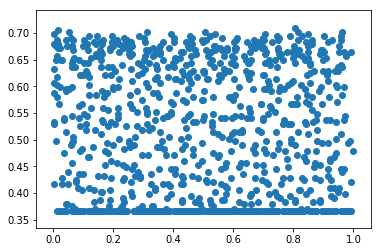

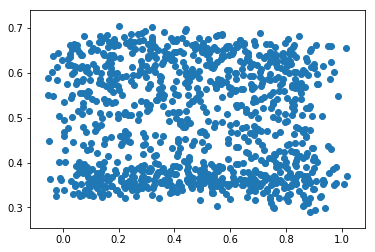

Valores en total para los 5 runs:
        Sen: Mean = 0.007704642601311207, STD = nan


In [10]:
runs = 1
sen = torch.zeros(runs)
df = torch.zeros(runs)

for i in range(runs):

    print("\nEntrenamiento para la trayectoria sen\n")

    (avg_train_loss_sen, avg_val_loss_sen) = setup_and_train(
            dataset= '/content/drive/My Drive/PARMA/OpticalFlow/GitRepo/Dataset/gt_tracking/Positions_sen.csv',
            dir_results='/content/drive/My Drive/PARMA/OpticalFlow/GitRepo/ElmanNetwork/Weigths and results/sen.csv',
            savefile='/content/drive/My Drive/PARMA/OpticalFlow/GitRepo/ElmanNetwork/Weigths and results/',
            loss="MSE",
            epochs=100,
            lr=0.1,
            std=0.1,
            run=i,
            batch_size=10)
    '''
    print("\nEntrenamiento para la trayectoria df\n")

    (avg_train_loss_df, avg_val_loss_df) = setup_and_train(
            dataset='/home/gerardo/Documents/Parma/Datasets/DF/Positions_df.csv',
            dir_results="/home/gerardo/Documents/TEC/IA/TP_4/Results/run2.csv",
            savefile="/home/gerardo/Documents/TEC/IA/TP_4/Checkpoints/DF/",
            loss="MSE",
            epochs=100,
            lr=0.1,
            std=0.01,
            run=i,
            batch_size=10)
    '''
    sen[i] = avg_val_loss_sen
    df[i] = 0#avg_val_loss_df

    print("""\nPara el run {} se obtuvieron los valores:
            Sen: Mean = {},
            DF: Mean = {}\n""".format(i, avg_val_loss_sen.item(), 0))

predict(load='/content/drive/My Drive/PARMA/OpticalFlow/GitRepo/ElmanNetwork/Weigths and results/weights0.pth',
            dataset='/content/drive/My Drive/PARMA/OpticalFlow/GitRepo/Dataset/gt_tracking/Positions_sen.csv',
            std=0.1)
'''
predict(load="/home/gerardo/Documents/TEC/IA/TP_4/Checkpoints/DF/weights0.pth",
            dataset='/home/gerardo/Documents/Parma/Datasets/DF/Positions_df.csv',
            std=0.01)
'''
avg_sen = sen.mean()
std_sen = sen.std()

avg_df = 0#df.mean()
std_df = 0#df.std()

print("""Valores en total para los 5 runs:
        Sen: Mean = {}, STD = {}""".format(avg_sen.item(), std_sen.item()))